In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c tabular-playground-series-may-2021

kaggle.json
  0% 0.00/851k [00:00<?, ?B/s]
100% 851k/851k [00:00<00:00, 58.2MB/s]
  0% 0.00/1.72M [00:00<?, ?B/s]
100% 1.72M/1.72M [00:00<00:00, 56.6MB/s]
  0% 0.00/128k [00:00<?, ?B/s]
100% 128k/128k [00:00<00:00, 124MB/s]


In [ ]:
!pip install catboost
!pip install eli5
!pip install shap
!unzip /content/test.csv.zip
!unzip /content/train.csv.zip
!unzip /content/sample_submission.csv.zip

     |████████████████████████████████| 67.3MB 82kB/s 
     |████████████████████████████████| 112kB 3.7MB/s 
     |████████████████████████████████| 358kB 3.8MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491632 sha256=00797594beb5cddda957df623172bc9b1fe77c0f1db5675cf425e478b649e24c
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap
Archive:  /content/test.csv.zip
  inflating: test.csv                
Archive:  /content/train.csv.zip
  inflating: train.csv               
Archive:  /content/sample_submission.csv.zip
  inflating: sample_submission.csv   


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn import metrics
from typing import List, Optional
from sklearn.model_selection import KFold, cross_val_score
from typing import List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
import math
import eli5
import time
import lightgbm as lgb
import shap
import missingno as msno
from sklearn.inspection import permutation_importance
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import train_test_split, KFold

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
def get_input(data_path: str) -> pd.DataFrame:
  """
  Считывание данных и вывод основной информации о наборе данных.

  Parmeters
  ---------
  data_path: str - название файла

  Returns
  -------
  data: pandas.core.frame.DataFrame - загруженный набор данных в pandas.Dataframe
  """
  base_path = "/content"
  data = pd.read_csv(f"{base_path}/{data_path}")
  data.columns = [col.lower() for col in data.columns]
  print(f"{data_path}: shape = {data.shape[0]} rows, {data.shape[1]} cols")
  return data

In [ ]:
def get_target_statistics(df: pd.DataFrame, tagret: str) -> pd.DataFrame:
    
    """
    Функция для вычисления распределения целевой переменной в задаче классификации.

    Parameters
    ----------
    df: pandas.core.DataFrame
        Набор данных.
    
    tagret: str
        Название целевой переменной

    Returns
    -------
    statistics: pandas.core.DataFrame
    
    """

    statistics = df.target.value_counts().reset_index()
    statistics.rename(columns = {"index": 'target value', tagret: 'num'}, inplace=True)
    statistics['percent'] = statistics['num']/sum(statistics['num'])
    sns.barplot(x=statistics['target value'], y=statistics['percent'])
    return statistics

In [ ]:
def plot_feature_importance(importance, names, model_type):

  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

  #Define size of bar plot
  plt.figure(figsize=(10,8))
  #Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
  #Add chart labels
  plt.title(model_type + ' FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')
  return list(fi_df['feature_names'].values)

In [ ]:
train = get_input("train.csv")
test = get_input("test.csv")
sample_submission = get_input("sample_submission.csv")

train.csv: shape = 100000 rows, 52 cols
test.csv: shape = 50000 rows, 51 cols
sample_submission.csv: shape = 50000 rows, 5 cols


In [ ]:
def get_nunique(df: pd.DataFrame) -> pd.DataFrame:
  result = {}
  columns = df.columns.to_list()
  for feature in columns:
    result[feature] = train[feature].nunique()
  return result

In [ ]:
get_nunique(train)

{'feature_0': 11,
 'feature_1': 31,
 'feature_10': 17,
 'feature_11': 13,
 'feature_12': 12,
 'feature_13': 4,
 'feature_14': 52,
 'feature_15': 21,
 'feature_16': 20,
 'feature_17': 17,
 'feature_18': 14,
 'feature_19': 58,
 'feature_2': 7,
 'feature_20': 18,
 'feature_21': 36,
 'feature_22': 5,
 'feature_23': 20,
 'feature_24': 35,
 'feature_25': 23,
 'feature_26': 22,
 'feature_27': 32,
 'feature_28': 24,
 'feature_29': 14,
 'feature_3': 26,
 'feature_30': 43,
 'feature_31': 46,
 'feature_32': 30,
 'feature_33': 25,
 'feature_34': 26,
 'feature_35': 44,
 'feature_36': 4,
 'feature_37': 15,
 'feature_38': 71,
 'feature_39': 70,
 'feature_4': 38,
 'feature_40': 22,
 'feature_41': 31,
 'feature_42': 40,
 'feature_43': 33,
 'feature_44': 10,
 'feature_45': 27,
 'feature_46': 30,
 'feature_47': 26,
 'feature_48': 45,
 'feature_49': 21,
 'feature_5': 11,
 'feature_6': 28,
 'feature_7': 32,
 'feature_8': 37,
 'feature_9': 18,
 'id': 100000,
 'target': 4}

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 52 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          100000 non-null  int64 
 1   feature_0   100000 non-null  int64 
 2   feature_1   100000 non-null  int64 
 3   feature_2   100000 non-null  int64 
 4   feature_3   100000 non-null  int64 
 5   feature_4   100000 non-null  int64 
 6   feature_5   100000 non-null  int64 
 7   feature_6   100000 non-null  int64 
 8   feature_7   100000 non-null  int64 
 9   feature_8   100000 non-null  int64 
 10  feature_9   100000 non-null  int64 
 11  feature_10  100000 non-null  int64 
 12  feature_11  100000 non-null  int64 
 13  feature_12  100000 non-null  int64 
 14  feature_13  100000 non-null  int64 
 15  feature_14  100000 non-null  int64 
 16  feature_15  100000 non-null  int64 
 17  feature_16  100000 non-null  int64 
 18  feature_17  100000 non-null  int64 
 19  feature_18  100000 non-n

In [ ]:
train.head()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,3,0,0,21,0,0,0,0,0,0,Class_2
1,1,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Class_1
2,2,0,0,0,0,0,0,0,0,0,2,0,0,1,0,1,0,0,0,0,1,0,5,2,1,1,0,1,0,2,0,0,0,0,19,2,0,1,7,3,0,0,0,1,0,0,0,0,13,2,0,Class_1
3,3,0,0,0,0,0,0,0,3,0,0,0,0,0,1,7,11,1,0,3,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,4,0,0,0,0,0,0,0,0,0,1,0,Class_4
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,9,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,Class_2


,target value,num,percent
0,Class_2,57497,0.57497
1,Class_3,21420,0.21420
2,Class_4,12593,0.12593
3,Class_1,8490,0.08490


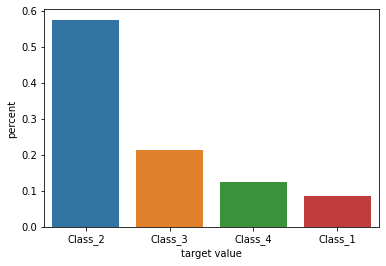

In [ ]:
get_target_statistics(train, 'target')

## Оценка линейной зависимости между признаками

Text(0, 0.5, 'Density')

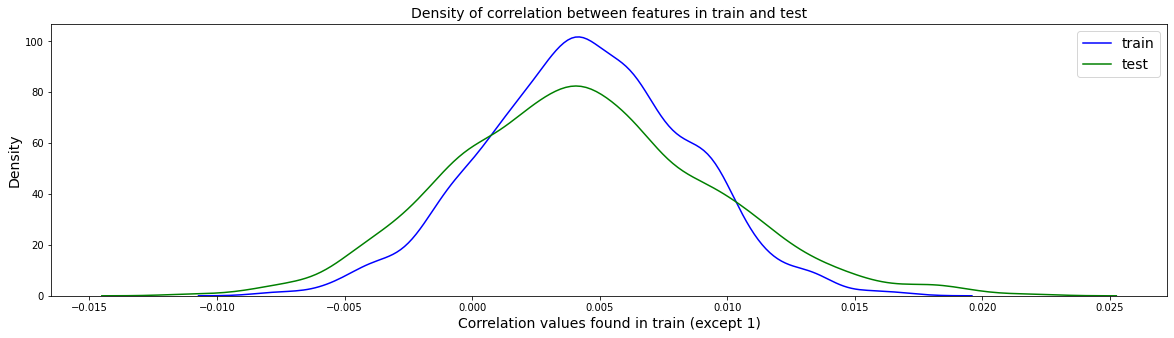

In [ ]:
train_correlations = train.drop(columns=['target']).corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

test_correlations = test.corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.kdeplot(train_correlations, color="Blue", label="train")
sns.kdeplot(test_correlations, color="Green", label="test")

plt.xlabel("Correlation values found in train (except 1)", size=14)
plt.title("Density of correlation between features in train and test", size=14)
plt.legend(loc="best", fontsize=14)
plt.ylabel("Density", size=14)

Корреляции признаков в train и test различаюся. Распределения признаков в этих выборках могут различаться

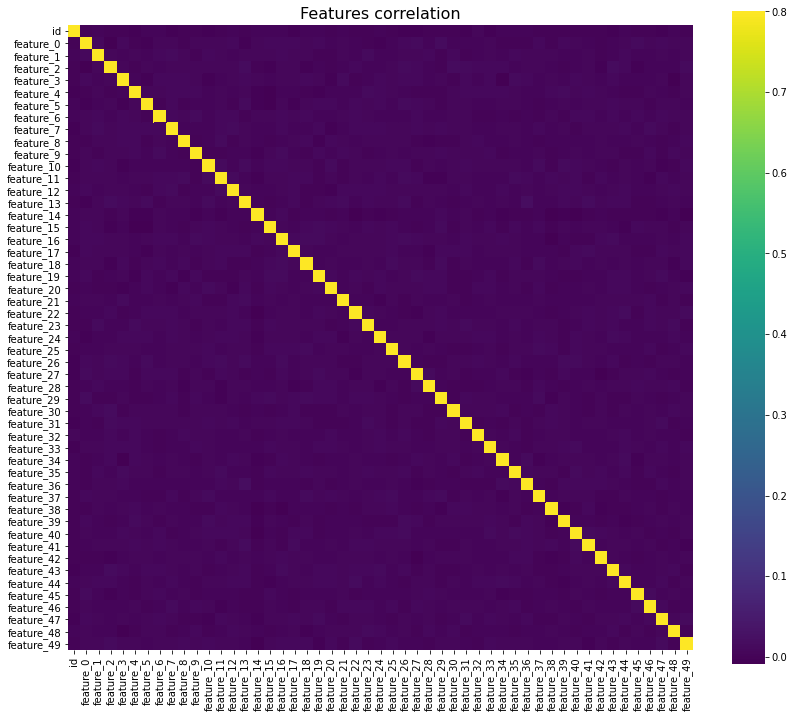

In [ ]:
correlation = train.corr()
fig, axes = plt.subplots(figsize = (14,12))
plt.title("Features correlation", y=1, size=16)
sns.heatmap(correlation, square=True, vmax=0.8, cmap="viridis")

## Распределения признаков в разрезе целевой переменной

In [ ]:
selected_features = train.columns.to_list()
selected_features.remove('id')
selected_features.remove('target')

In [ ]:
def show_distrib(dataset,
                 selected_features,
                 n_columns = 3, 
                 sublot_size: tuple = (5, 4),
                 space: float = 3.0):
    
    n_rows = math.ceil((len(selected_features) / n_columns))
    x1 = dataset[dataset['target']=='Class_1']
    x2 = dataset[dataset['target']=='Class_2']
    x3 = dataset[dataset['target']=='Class_3']
    x4 = dataset[dataset['target']=='Class_4']
    fig = plt.figure(figsize=(n_columns*sublot_size[0], n_rows*sublot_size[1]))
    for i,feature in enumerate(selected_features):
        ax = fig.add_subplot(n_rows, n_columns, i+1)
        ax.hist([x1[feature], x2[feature], x3[feature], x4[feature]], 
                label=['Class_1','Class_2', 'Class_3', 'Class_4'], 
                bins=10, 
                color=['r','g', 'b', 'k'],
                density=True)
        ax.legend(loc = 'upper right')
        ax.set_title('Distribution '+str(feature))
    plt.show()

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


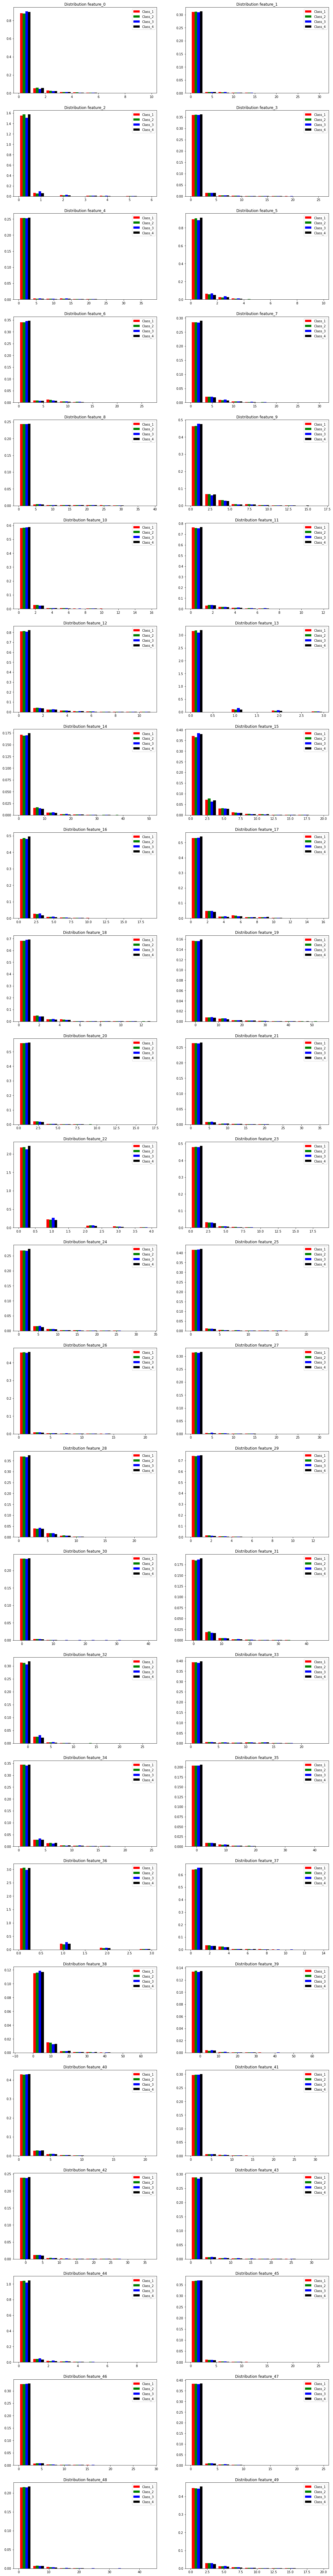

In [ ]:
show_distrib(train, selected_features, n_columns=2, sublot_size=(9, 6))

## Распределения признаков для train и test

In [ ]:
def train_test_distr(df_train: pd.DataFrame, 
                     df_test: pd.DataFrame, 
                     selected_features: List,
                     n_columns: int = 3,
                     sublot_size: tuple = (5, 4),
                     space: float = 3.0):

  n_rows = math.ceil((len(selected_features) / n_columns))

  fig = plt.figure(figsize=(n_columns*sublot_size[0], n_rows*sublot_size[1]))
  for i,feature in enumerate(selected_features):
      ax = fig.add_subplot(n_rows, n_columns, i+1)
      ax.hist([df_train[feature], df_test[feature]], 
              label=['Train','Test'], 
              bins=10, 
              color=['r','g'],
              density=True)
      ax.legend(loc = 'upper right')
      ax.set_title('Distribution '+str(feature))
  plt.show()

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


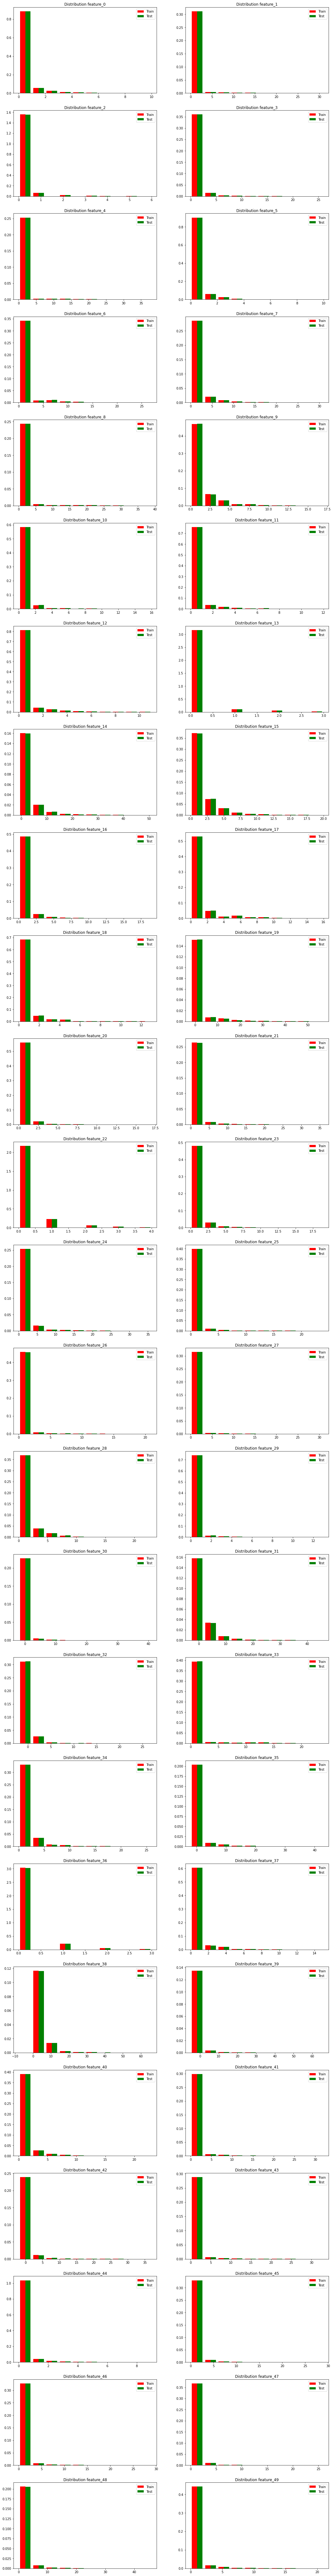

In [ ]:
train_test_distr(train, test, selected_features, n_columns=2, sublot_size=(9, 6))

## Признаки с нелинейной связью с целевой переменной

In [ ]:
y_train = train['target']
x_train = train.drop(columns=['target'])

In [ ]:
lgbm_params = {
    "boosting_type ": "gbdt",
    "objective": "multiclass",
    #"eval_metric": "auc",
    "learning_rate": 0.1,
    "num_boost_round": 290,
    "reg_lambda": 100,
    "max_depth": 3,
    "n_jobs": -1,
    "seed": 27,
    'device_type': 'cpu'
}

model_lgb = lgb.LGBMClassifier(**lgbm_params)
model_lgb.fit(x_train, y_train)

Found `num_boost_round` in params. Will use it instead of argument


LGBMClassifier(boosting_type='gbdt', boosting_type ='gbdt', class_weight=None,
               colsample_bytree=1.0, device_type='cpu', importance_type='split',
               learning_rate=0.1, max_depth=3, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_boost_round=290, num_leaves=31,
               objective='multiclass', random_state=None, reg_alpha=0.0,
               reg_lambda=100, seed=27, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

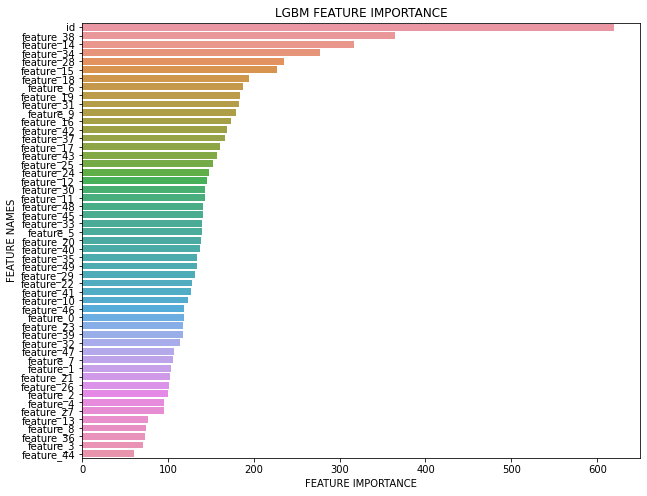

In [ ]:
top_features = plot_feature_importance(model_lgb.feature_importances_, x_train.columns, 'LGBM')

## Анализ идентичности распределения признаков в train и test через модель (adversarial validation) 

In [ ]:
def train_test_adv_validation(x_train: pd.DataFrame, 
                              x_test: pd.DataFrame, 
                              categorical_features: List = None):
  
  X_adv = pd.concat([x_train, x_test])
  y_adv = np.hstack((np.ones(x_train.shape[0]), np.zeros(x_test.shape[0])))

  X_adv = X_adv.reset_index(drop=True)

  if categorical_features != None:
    for feature in categorical_features:
      X_adv[feature] = pd.Series(X_adv[feature], dtype="category")
  
  dtrain = lgb.Dataset(data=X_adv, label=y_adv)
  
  lgbm_params = {
    "boosting_type ": "gbdt",
    "objective": "binary",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "reg_lambda": 100,
    "max_depth": 3,
    "n_jobs": -1,
    "seed": 27,
    'device_type': 'cpu'
  }

  cv_result = lgb.cv(
    params=lgbm_params,
    train_set=dtrain,
    num_boost_round=1000,
    #categorical_feature=categorical_features,
    early_stopping_rounds=100,
    verbose_eval=10,
    stratified=True,
    seed=42,
    metrics="auc",
    shuffle=True,
    nfold=5
  )
  
  lgbm_params['n_estimators'] = len(cv_result['auc-mean'])
  print(f"Training model with {lgbm_params['n_estimators']} estimators")

  model_lgb = lgb.LGBMClassifier(**lgbm_params)
  model_lgb.fit(X_adv, y_adv)
  importance = pd.DataFrame({
    "feature": X_adv.columns,
    "adversarial_importance": model_lgb.feature_importances_
  })
  importance = importance.sort_values(by="adversarial_importance", ascending=False)
  importance = importance.head(n=10)

  plt.figure(figsize=(20, 5))
  sns.barplot(x=importance["feature"], y=importance["adversarial_importance"], palette="viridis")
  plt.title("Top Importance Features for Adversarial Validation (train vs test)", size=14)
  return model_lgb

[10]	cv_agg's auc: 0.497976 + 0.00365909
[20]	cv_agg's auc: 0.497109 + 0.00387619
[30]	cv_agg's auc: 0.496612 + 0.00382159
[40]	cv_agg's auc: 0.497231 + 0.00392498
[50]	cv_agg's auc: 0.497069 + 0.00394909
[60]	cv_agg's auc: 0.497067 + 0.00376936
[70]	cv_agg's auc: 0.496607 + 0.00342294
[80]	cv_agg's auc: 0.497093 + 0.00316276
[90]	cv_agg's auc: 0.496934 + 0.00315996
[100]	cv_agg's auc: 0.496786 + 0.0030928
Training model with 1 estimators


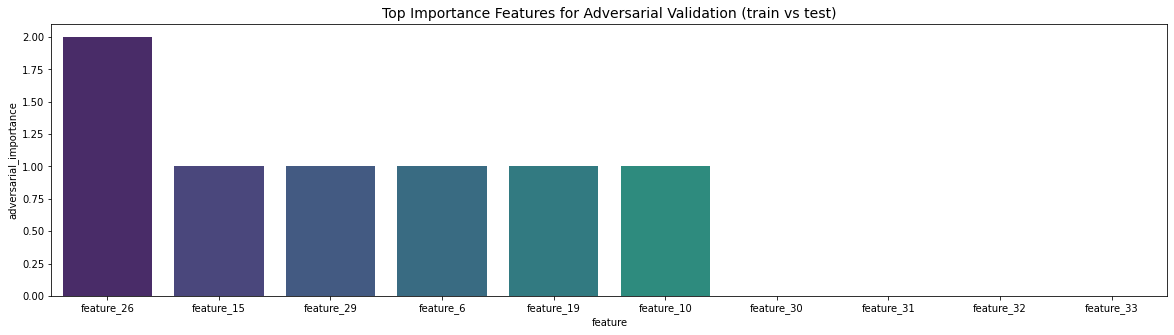

In [ ]:
lgb_model = train_test_adv_validation(x_train.drop(columns=['id']), test.drop(columns=['id']))

Алгоритм не различает train и test